## Declared users

In [1]:
from pathlib import Path
import numpy as np

import sys
sys.path += ['../src/']

from utils import load_data
import yaml

# 1. Define paths
with open("../scripts/parameters.yaml", 'r') as stream:
    parameters = yaml.safe_load(stream)
dataset_path = Path(parameters['dataset_path'])
input_path = Path(parameters['input_path'])
subreddit_names = np.load(input_path / Path("list_subreddits.npy"), allow_pickle=True)
DIMENSIONS = ['demo_rep', 'year', 'gender']

In [2]:
# Build random sample for control group

from scipy.sparse import coo_matrix, csr_matrix, save_npz, load_npz
import pandas as pd
import numpy as np
from pathlib import Path
import psutil
import time

def count_lines(file_path: Path) -> int:
    with open(file_path, "rb") as f:
        return sum(1 for _ in f) - 1

def create_sparse_matrix_sampled(
    subreddit_names: list,
    attribute_path: Path,
    sample_frac: float = 0.25,
    use_bool_features: bool = True,
    chunk_size: int = 5_000_000,
    save_path: Path = None,
    return_loaded_if_exists: bool = True,
) -> csr_matrix:
    """Build a sampled sparse matrix and save filtered y_control_sampled.csv."""
    
    if save_path is None:
        save_path = attribute_path / "X_control_sampled.npz"
    y_output_path = attribute_path / "y_control_sampled.csv"

    if save_path.exists() and y_output_path.exists():
        print(f"✅ Files already exist:\n  - {save_path}\n  - {y_output_path}")
        if return_loaded_if_exists:
            print("📥 Loading existing matrix...")
            return load_npz(save_path)
        else:
            print("⏩ Skipping matrix creation.")
            return None

    process = psutil.Process()
    X_file = attribute_path / "X.csv"
    total_lines = count_lines(X_file)
    total_chunks = (total_lines + chunk_size - 1) // chunk_size
    estimated_sampled = int(total_lines * sample_frac)

    subreddit2index = {sub: i for i, sub in enumerate(subreddit_names)}
    subreddit_set = set(subreddit2index)

    y_df = pd.read_csv(attribute_path / "y.csv").drop_duplicates(subset="author")
    author2index = {auth: i for i, auth in enumerate(y_df["author"])}
    index2author = {i: auth for auth, i in author2index.items()}
    author_set = set(author2index)

    data = []
    rows = []
    cols = []
    sampled_rows = 0
    start_time = time.time()

    for i, chunk in enumerate(pd.read_csv(X_file, chunksize=chunk_size)):
        chunk = chunk[chunk["author"].isin(author_set) & chunk["subreddit"].isin(subreddit_set)]
        if chunk.empty:
            continue

        chunk = chunk.sample(frac=sample_frac, random_state=42 + i)

        row_idx = chunk["author"].map(author2index).values
        col_idx = chunk["subreddit"].map(subreddit2index).values
        val = np.ones_like(row_idx) if use_bool_features else chunk["count"].values

        rows.extend(row_idx)
        cols.extend(col_idx)
        data.extend(val)

        sampled_rows += len(chunk)
        pct = (i + 1) / total_chunks * 100
        mem_gb = process.memory_info().rss / 1e9
        print(
            f"[Chunk {i+1}/{total_chunks}] Sampled {len(chunk):,} rows | "
            f"Total: {sampled_rows:,}/{estimated_sampled:,} | "
            f"Mem: {mem_gb:.2f} GB | Done: {pct:.1f}%"
        )

    full_X = coo_matrix((data, (rows, cols)), shape=(len(author2index), len(subreddit2index))).tocsr()

    # Keep only non-zero rows
    nonzero_mask = full_X.getnnz(axis=1) > 0
    X_sparse = full_X[nonzero_mask]

    save_npz(save_path, X_sparse)
    print(f"\n✅ Saved sparse matrix to {save_path}")
    print(f"🔢 Final shape: {X_sparse.shape}, nnz: {X_sparse.nnz:,}")
    print(f"⏱️ Total time: {time.time() - start_time:.1f}s")

    # Write corresponding filtered y.csv
    kept_indices = np.where(nonzero_mask)[0]
    filtered_y_df = pd.DataFrame([index2author[i] for i in kept_indices], columns=["author"])
    filtered_y_df = filtered_y_df.merge(y_df, on="author", how="left")
    filtered_y_df.to_csv(y_output_path, index=False)
    print(f"📝 Saved corresponding authors to {y_output_path}")

    return X_sparse
    

X_control_sampled = create_sparse_matrix_sampled(
    subreddit_names=subreddit_names,
    attribute_path=Path(dataset_path) / "control_group",
    sample_frac=0.5,
    use_bool_features=True,
    chunk_size=5_000_000
)

✅ Files already exist:
  - ../data/dataset/control_group/X_control_sampled.npz
  - ../data/dataset/control_group/y_control_sampled.csv
📥 Loading existing matrix...


In [4]:
DIMENSION2ACTIVITY = {}


for dimension in DIMENSIONS:
    print(f"\n---> DIMENSION: {dimension}")
    
    # Load data
    print(" -- declaration data:")
    X_declarations, _y_declarations = load_data(attribute_path=dataset_path / Path(f"{dimension}__body"),
                                               attribute_to_label=None,
                                               input_path=input_path,
                                               use_bool_features=False,
                                               save=True)
    DIMENSION2ACTIVITY[dimension] = X_declarations


NUMB_USERS = sum([X.shape[0] for X in DIMENSION2ACTIVITY.values()])
print(f"NUMB_USERS: {NUMB_USERS:_}")


---> DIMENSION: demo_rep
 -- declaration data:

   Scipy sparse data matrices already exist at ../data/dataset/demo_rep__body:  loading them
Loaded data X:(5864, 10000), y:(5864,)  ✅

---> DIMENSION: year
 -- declaration data:

   Scipy sparse data matrices already exist at ../data/dataset/year__body:  loading them
Loaded data X:(382429, 10000), y:(382429,)  ✅

---> DIMENSION: gender
 -- declaration data:

   Scipy sparse data matrices already exist at ../data/dataset/gender__body:  loading them
Loaded data X:(383467, 10000), y:(383467,)  ✅
NUMB_USERS: 771_760


----------

# ANALYSIS

In [ ]:
from scipy.sparse import vstack
import numpy as np
from scipy import sparse

def l1_normalize_sparse_rows(X):
    """
    L1-normalize rows of a CSR sparse matrix (i.e., row sum = 1).
    """
    row_sums = np.array(X.sum(axis=1)).flatten()
    row_sums[row_sums == 0] = 1  # avoid division by zero
    inv_row_sums = 1.0 / row_sums
    diag_inv = sparse.diags(inv_row_sums)
    return diag_inv.dot(X)

def restrict_to_common_columns(X1, X2):
    """
    Restrict two CSR sparse matrices to only columns (subreddits)
    that have non-zero entries in both.
    """
    # Get non-zero column indices for each matrix
    nonzero_cols_1 = np.unique(X1.nonzero()[1])
    nonzero_cols_2 = np.unique(X2.nonzero()[1])

    # Intersection of active columns
    common_cols = np.intersect1d(nonzero_cols_1, nonzero_cols_2)

    print(f"common_cols: {len(common_cols)}/{X1.shape[1]}")

    # Slice matrices to those columns
    X1_reduced = X1[:, common_cols]
    X2_reduced = X2[:, common_cols]

    return X1_reduced, X2_reduced, common_cols




# Creating matrices
X1 = vstack([
    DIMENSION2ACTIVITY['year'],
    DIMENSION2ACTIVITY['gender'],
    DIMENSION2ACTIVITY['demo_rep']
])
X2 = X_control_sampled

print(f"Treatment: {X1.shape},   Control: {X2.shape}")


Treatment: (771760, 10000),   Control: (2968999, 10000)


In [87]:
import numpy as np
from scipy.sparse import csr_matrix

np.random.seed(0)

def sample_sparse_rows(X, n=5, seed=42):
    rng = np.random.default_rng(seed)
    indices = rng.choice(X.shape[0], size=min(n, X.shape[0]), replace=False)
    return X[indices]

n = 10_000

print(f"{n/X1.shape[0]:%}")

# Example: sample 5 rows from X1 and X2
X1_sample = sample_sparse_rows(X1, n=n)
X2_sample = X2

#X1_sample, X2_sample, shared_subreddits = restrict_to_common_columns(X1_sample, X2_sample)

1.295740%


In [88]:
# 2. Activity matching

TEST = True

import numpy as np
from sklearn.neighbors import NearestNeighbors

def match_users_by_activity(X1, X2):
    # Get user activity levels (sparse row sums)
    a1 = np.array(X1.sum(axis=1)).flatten().reshape(-1, 1)
    a2 = np.array(X2.sum(axis=1)).flatten().reshape(-1, 1)

    # Match Group 1 users to closest Group 2 users by activity (1D!)
    nn = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='manhattan')
    nn.fit(a2)
    _, indices = nn.kneighbors(a1)

    # Allow repeated matches (fastest path)
    X2_matched = X2[indices.flatten()]

    return X1, X2_matched
    


X1_matched, X2_matched = match_users_by_activity(X1_sample, X2_sample) if TEST else match_users_by_activity(X1, X2)

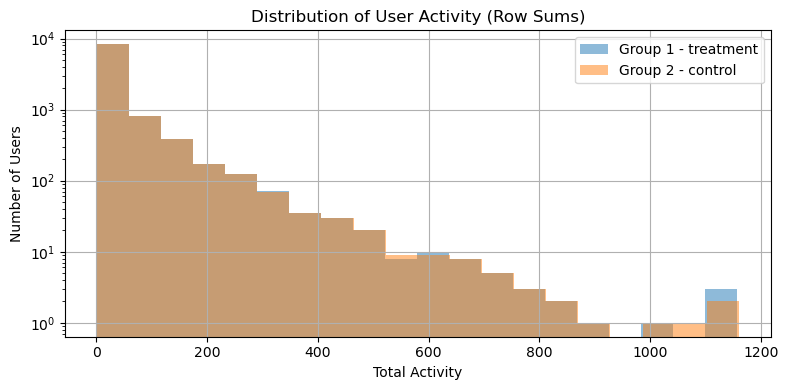

In [89]:
import matplotlib.pyplot as plt

activity1 = np.array(X1_matched.sum(axis=1)).flatten()
activity2 = np.array(X2_matched.sum(axis=1)).flatten()

plt.figure(figsize=(8, 4))
plt.hist(activity1, bins=20, alpha=0.5, label='Group 1 - treatment')
plt.hist(activity2, bins=20, alpha=0.5, label='Group 2 - control')
plt.title('Distribution of User Activity (Row Sums)')
plt.xlabel('Total Activity')
plt.ylabel('Number of Users')
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Q-Q plots

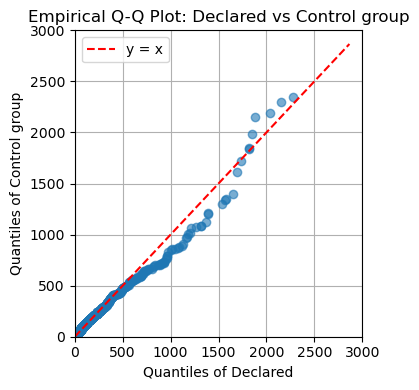

0.40217536868130344

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Example: comparing row sums from two subreddits groups
group1 = np.asarray(X1_matched.sum(axis=0)).flatten()
group2 = np.asarray(X2_matched.sum(axis=0)).flatten()

LIM = 3000#np.inf

ok_indices = np.where(group1<LIM)[0]
group1 = group1[ok_indices]
group2 = group2[ok_indices]

# Normalization step:
group2 = np.round(group1.sum() * group2 / group2.sum())

# Sort the values to get quantiles
group1_sorted = np.sort(group1)
group2_sorted = np.sort(group2)

# Trim to equal length for Q-Q plot
min_len = min(len(group1_sorted), len(group2_sorted))
group1_sorted = group1_sorted[:min_len]
group2_sorted = group2_sorted[:min_len]

# Plot Q-Q comparison
plt.figure(figsize=(4, 4))
plt.plot(group1_sorted, group2_sorted, 'o', alpha=0.6)
plt.plot([group1_sorted.min(), group1_sorted.max()],
         [group1_sorted.min(), group1_sorted.max()],
         'r--', label='y = x')
plt.xlabel("Quantiles of Declared")
plt.ylabel("Quantiles of Control group")
if LIM < np.inf:
    plt.xlim(0, LIM)
    plt.ylim(0, LIM)
plt.title("Empirical Q-Q Plot: Declared vs Control group")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()